# Electricity Load Forecasting — Data Preparation & Feature Engineering

This notebook combines the **data preparation**, **exploratory analysis**, and **feature engineering** phases for the Electricity Load Forecasting project.

It ensures that all steps leading to model training (XGBoost, LSTM, TFT) are well-documented, reproducible, and visually explained.

## 🔹 1. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

sys.path.append(os.path.join(os.path.dirname("__file__"), '..', 'src'))
project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
data_path = os.path.join(project_root, "data/raw/continuous_dataset.csv")
reports_path = os.path.join(project_root, "reports")

os.makedirs(os.path.join(project_root, "data/worked"), exist_ok=True)
os.makedirs(os.path.join(reports_path, "data_prep"), exist_ok=True)
os.makedirs(os.path.join(reports_path, "EDA"), exist_ok=True)
os.makedirs(os.path.join(reports_path, "feature_engineering"), exist_ok=True)

## 🔹 2. Load Raw Data

In [2]:
df = pd.read_csv(data_path, parse_dates=['datetime'])
print(f"Loaded dataset shape: {df.shape}")
df.head()

Loaded dataset shape: (48048, 17)


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


## 🔹 3. Data Cleaning
In this phase, the goal was to ensure that the dataset is consistent, continuous, and free of structural anomalies before any modeling.
The raw electricity demand data often contains **missing timestamps, duplicate rows, and misaligned time indices**, which can easily mislead models trained on temporal patterns.
The cleaning process (handled inside `data_prep.py`) performs several key steps:

* **Datetime Conversion**: Converts the `datetime` column to a true timestamp type for easier manipulation.
* **Sorting & Continuity Check**: Ensures the data follows chronological order and identifies missing hourly intervals.
* **Duplicate Removal**: Drops duplicate timestamp entries to maintain one observation per hour.
* **Missing Value Handling**: If any short gaps exist, they are filled logically using forward-fill or interpolation to preserve trend continuity.
* **Verification**: The script prints time coverage and missing timestamp counts to confirm data completeness.
This ensures the time series is fully consistent and suitable for lag/rolling window feature creation later.

Finally, the cleaned dataset is saved to `data/worked/cleaned_continuous_dataset.csv` for reproducibility.
We'll use the `clean_data()` function from **data_prep.py**. This function:

(48048, 17)
              count                 mean                  min  \
datetime      48048  2017-09-30 00:30:00  2015-01-03 01:00:00   
nat_demand  48048.0          1182.868647              85.1925   
T2M_toc     48048.0            27.399111            22.953455   
QV2M_toc    48048.0             0.018313             0.012054   
TQL_toc     48048.0             0.079979                  0.0   
W2M_toc     48048.0            13.391049             0.008979   
T2M_san     48048.0            26.921023            19.765222   
QV2M_san    48048.0             0.017844             0.010247   
TQL_san     48048.0             0.106265             0.000009   
W2M_san     48048.0             7.046675             0.060394   
T2M_dav     48048.0            24.719513             19.93374   
QV2M_dav    48048.0             0.016867             0.009655   
TQL_dav     48048.0             0.144681             0.000032   
W2M_dav     48048.0             3.567589             0.015497   
Holiday_ID  4

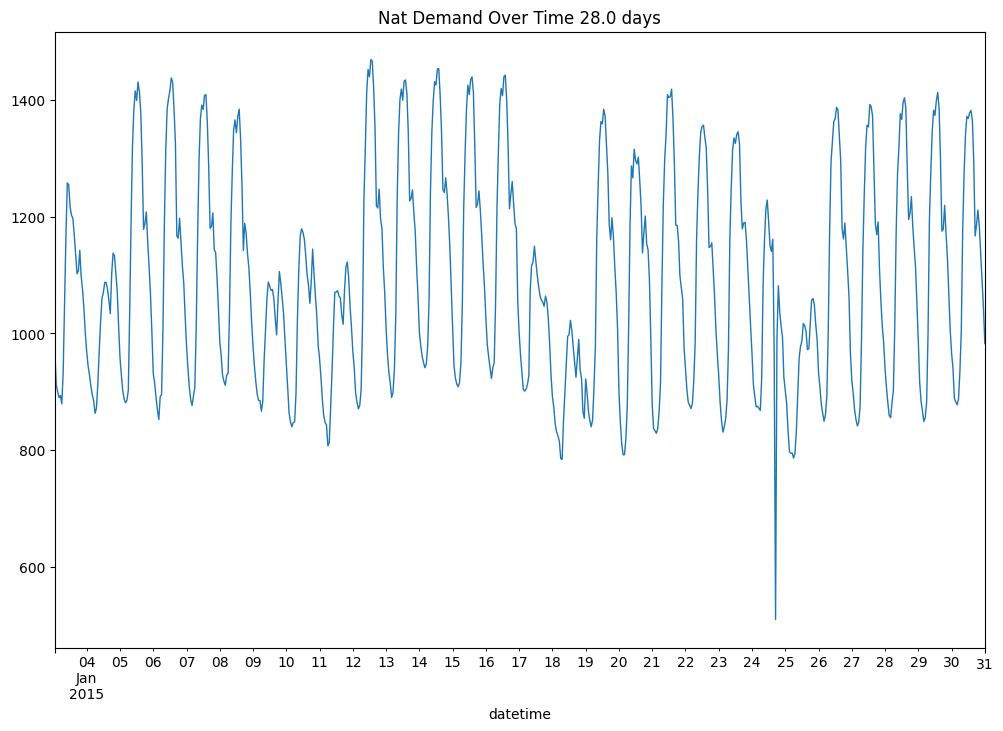

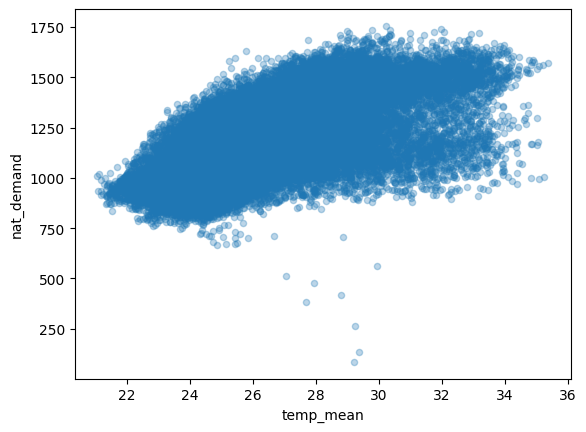

Cleaned dataset shape: (48048, 19)


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,temp_mean,temp_range
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0,24.003280,3.203125
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0,23.959151,3.320312
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0,23.937280,3.406250
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0,23.902856,3.445312
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0,23.843632,3.492188


In [3]:
from data_prep import clean_data

cleaned_df = clean_data(
    df,
    os.path.join(project_root, 'data/worked'),
    os.path.join(reports_path, 'data_prep')
)

print(f"Cleaned dataset shape: {cleaned_df.shape}")
cleaned_df.head()

As seen above, the dataset spans from 2015 to mid-2020 with no missing hourly timestamps after cleaning, confirming it’s suitable for time-series modeling.

## 🔹 4. Exploratory Data Analysis (EDA)

EDA helps understand the dataset’s dynamics — identifying **seasonal demand patterns**, weekly cycles, and anomalies such as the COVID-19 demand drop.
Some of the key insights explored in this step:

* **Demand Seasonality**: Electricity demand follows daily and weekly cycles, peaking during work hours and dropping at night or weekends.
* **COVID Impact Analysis**: Using a binary flag `covid_period`, I compared average pre-COVID vs post-COVID demand.
This revealed about a 5.8% relative drop during the pandemic — confirming expected consumption reduction.
* **Weather Correlation**: The dataset included weather conditions (`T2M`, `QV2M`, `TQL`, `W2M`) from three regions (Toc, San, Dav).
Since these are strongly correlated, we later use PCA (Principal Component Analysis) to combine them into fewer, uncorrelated components.
* **Outlier Detection**: Visual trend analysis and correlation plots help spot any sudden dips or spikes possibly caused by missing data or abnormal events.

The full diagnostic plots (seasonality, holidays, autocorrelation, etc.) are saved under the `reports/EDA` folder.

In this notebook, we only display a few key visuals summarizing demand behavior and correlations.

In [4]:
from EDA import EDA

eda_df = EDA(
    cleaned_df,
    os.path.join(project_root, 'data'),
    os.path.join(reports_path, 'EDA'),
    verbose=False
)

(48048, 18)
Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school', 'temp_mean',
       'temp_range'],
      dtype='object')
                     nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
datetime                                                                    
2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

                       T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  \
datetime                                                                   
2015-01-03 01:00:00  23.482446  0.

### Example visual checks:

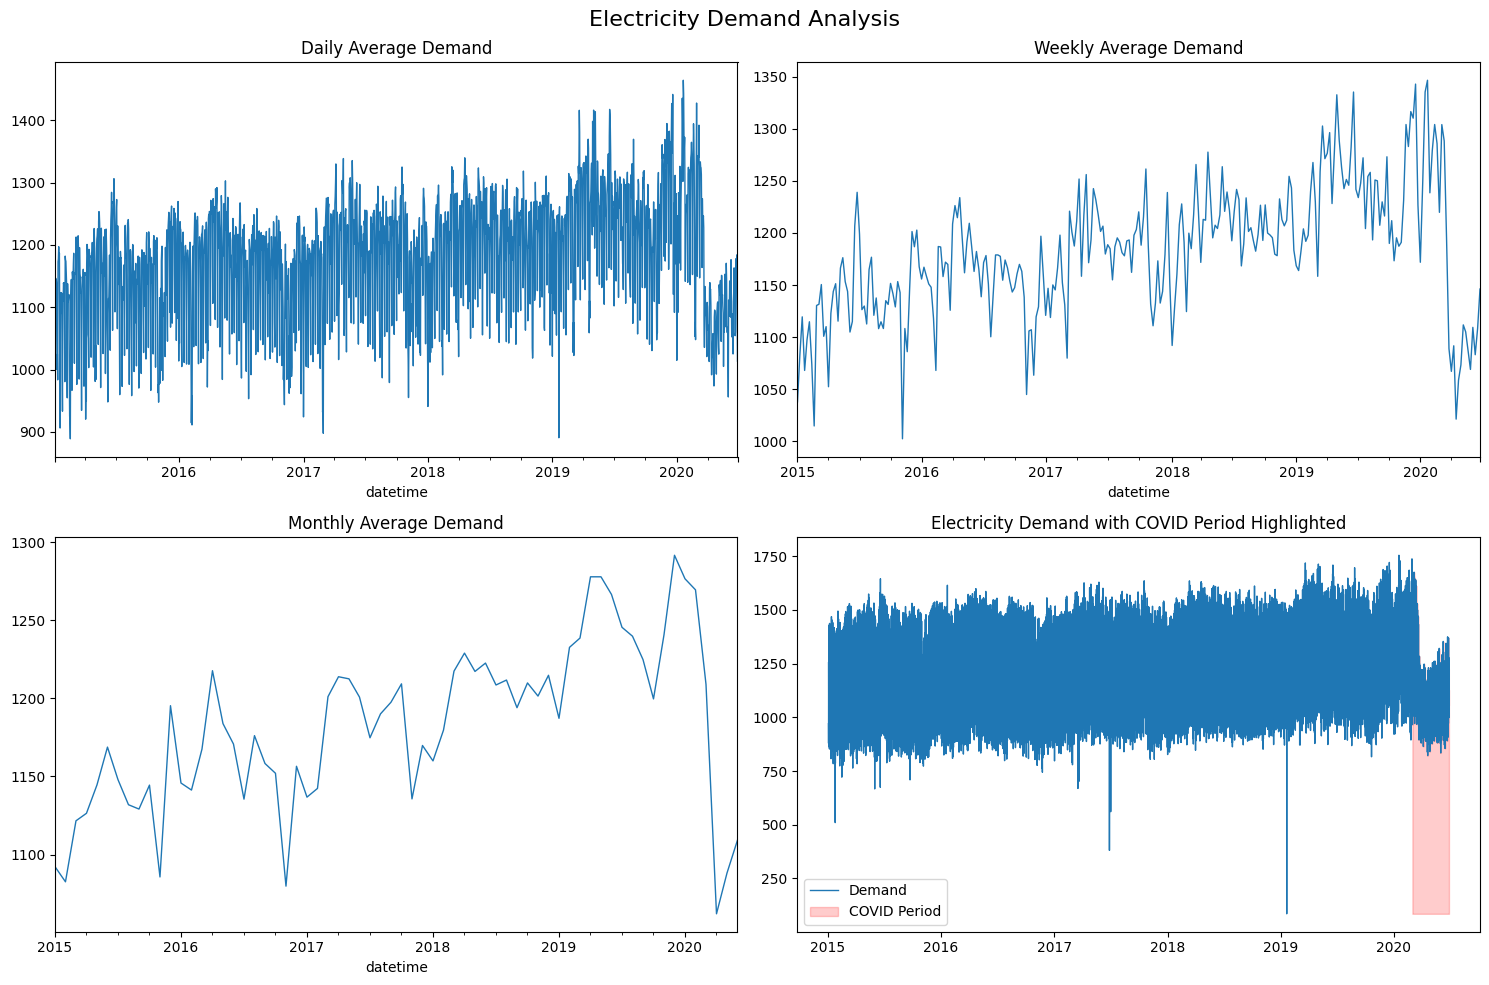

In [5]:
test_eda_df = eda_df.set_index('datetime')
# Electricity Demand Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Electricity Demand Analysis', fontsize=16)

# Daily mean
test_eda_df['nat_demand'].resample('D').mean().plot(ax=axes[0, 0], title='Daily Average Demand', lw=1)

# Weekly mean
test_eda_df['nat_demand'].resample('W').mean().plot(ax=axes[0, 1], title='Weekly Average Demand', lw=1)

# Monthly mean
test_eda_df['nat_demand'].resample('ME').mean().plot(ax=axes[1, 0], title='Monthly Average Demand', lw=1)

# Looking at the graphs we can see Covid makes the demand drop drastically
# to make it work without any issues later i'll implement covid_period column
# COVID dates 2020-03-01 -> 2020-06-27

# COVID period visualization
axes[1, 1].plot(test_eda_df.index, test_eda_df['nat_demand'], label='Demand', lw=1)
axes[1, 1].fill_between(test_eda_df.index, test_eda_df['nat_demand'].min(), test_eda_df['nat_demand'],
                    where=test_eda_df['covid_period']==1, color='red', alpha=0.2, label='COVID Period')
axes[1, 1].set_title('Electricity Demand with COVID Period Highlighted')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 🔹 5. Feature Engineering

The goal of feature engineering in this project was to expose the underlying drivers of electricity demand: daily and weekly consumption patterns, weather influence, and behavioral effects such as holidays and weekends. The final feature set was selected through several iterations of experimentation and validation.

The final set of engineered features includes:

---

### 1) Temporal Memory (Lag Features)

Electricity demand is highly dependent on recent consumption. To provide the models with meaningful historical context, the following lag features were created:

| Feature | Interpretation |
|--------|----------------|
| `lag_1` | Demand one hour ago (captures short-term signal) |
| `lag_24` | Demand at the same hour yesterday (captures daily seasonality) |
| `lag_168` | Demand one week ago (captures weekly behavioral patterns) |

These three lags consistently proved to be the most informative while keeping the feature space compact.

---

### 2) Weather Feature Compression (PCA)

Weather variables from multiple regions were strongly correlated. To avoid multicollinearity and reduce noise, Principal Component Analysis was applied:

- Applied **Principal Component Analysis (PCA)**  
- Reduced **9 raw weather variables** down to **3 principal components**: 

    `weather_pc1`, `weather_pc2`, `weather_pc3`. 

These components retain the majority of variance in the original weather data while being compact and more stable for modeling.

---


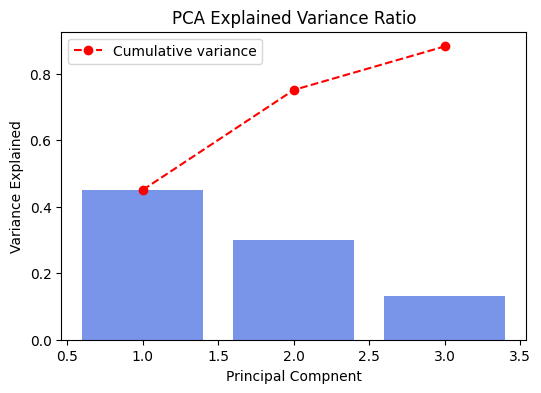

In [9]:
from feature_engineering import feature_engineering, weather_pca
df = weather_pca(eda_df)


### 3) Cyclical Encoding of Time

Time-based features repeat in cycles (e.g., hours of the day, days of the week). Instead of treating them as linear numbers, they were encoded using sine and cosine transformations:

    hour → hour_sin, hour_cos

    dayofweek → dow_sin, dow_cos

    month → month_sin, month_cos


This allows models to learn meaningful temporal structure (e.g., hour 23 and hour 0 are close).

---

### 4) Event and Behavioral Indicators

| Feature | Purpose |
|--------|---------|
| `holiday` | Represents abnormal demand patterns on holidays |
| `Holiday_ID` | Differentiates types of holidays |
| `school` | Indicates school-term vs. vacation periods |
| `is_weekend` | Captures weekend consumption behavior changes |

These features introduce social and calendar-based variation into the model.

---

### 5) Removed and Refined Feature Groups

Through experimentation, certain engineered features were removed because they either introduced noise or were redundant:

| Feature Group | Action | Reason |
|--------------|--------|--------|
| Rolling statistics (`roll_*`) | Removed | They smoothed out important peak behavior and risked data leakage. |
| Difference features (`diff_*`) | Removed | Increased variance without improving prediction accuracy. |
| Exponential weighted averages (`ewm_*`) | Removed | Redundant once PCA and lag features were included. |


---

### 6) Model-Specific Feature Usage

Different model architectures leverage temporal information differently. The feature set was adapted accordingly:

| Model | Input Strategy | Rationale |
|------|----------------|-----------|
| **XGBoost** | Uses full engineered feature set including `lag_1`, `lag_24`, `lag_168`, PCA weather, and event indicators. | Tree-based models benefit from having historical information explicitly provided. |
| **LSTM** | Uses raw scaled features without diff features, trained on sequences of **168 hours**. | LSTMs learn temporal patterns directly through sequence memory. |
| **TFT** (Temporal Fusion Transformer) | Uses engineered features but **keeps only `lag_24` and `lag_168`**, and excludes diff features. | TFT models learn temporal dependencies via attention, supported by key lag signals. |

---

### Summary

This feature engineering strategy captures the dominant drivers of electricity demand: short-term fluctuations, daily/weekly seasonality, weather effects, and social calendar behavior. The result is a balanced and interpretable feature set that supports both tree models and sequence-based deep learning models effectively.






In [7]:

eng_df,_,_ = feature_engineering(
    eda_df,
    os.path.join(project_root, 'data'),
    os.path.join(reports_path, 'feature_engineering'),
    verbose=False
)

print(f"Feature-engineered dataset shape: {eng_df.shape}")
eng_df.head()

Index(['datetime', 'nat_demand', 'TQL_toc', 'TQL_san', 'TQL_dav', 'Holiday_ID',
       'holiday', 'school', 'temp_mean', 'temp_range', 'covid_period', 'hour',
       'dayofweek', 'weather_pc1', 'weather_pc2', 'weather_pc3', 'lag_1',
       'lag_24', 'lag_168', 'year', 'month', 'week', 'day', 'is_weekend',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'diff_1', 'diff_24',
       'diff_168', 'hour_x_weekend', 'hour_x_school'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47880 entries, 0 to 47879
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        47880 non-null  datetime64[ns]
 1   nat_demand      47880 non-null  float64       
 2   TQL_toc         47880 non-null  float64       
 3   TQL_san         47880 non-null  float64       
 4   TQL_dav         47880 non-null  float64       
 5   Holiday_ID      47880 non-null  int64         
 6   holiday   

,datetime,nat_demand,TQL_toc,TQL_san,TQL_dav,Holiday_ID,holiday,school,temp_mean,temp_range,...,is_weekend,month_sin,month_cos,dow_sin,dow_cos,diff_1,diff_24,diff_168,hour_x_weekend,hour_x_school
0,2015-01-10 01:00:00,906.9580,0.025253,0.051376,0.121826,0,0,0,23.606704,2.687500,...,1,0.5,0.866025,-0.974928,-0.222521,-42.5451,-36.6501,-63.3870,1,0
1,2015-01-10 02:00:00,863.5135,0.034378,0.038712,0.117706,0,0,0,23.544295,2.609375,...,1,0.5,0.866025,-0.974928,-0.222521,-43.4445,-53.5505,-48.6620,2,0
2,2015-01-10 03:00:00,848.4447,0.045349,0.028526,0.123718,0,0,0,23.504724,2.554688,...,1,0.5,0.866025,-0.974928,-0.222521,-15.0688,-47.4645,-51.8241,3,0
3,2015-01-10 04:00:00,839.8821,0.047501,0.016182,0.123779,0,0,0,23.527714,2.539062,...,1,0.5,0.866025,-0.974928,-0.222521,-8.5626,-45.3899,-50.0717,4,0
4,2015-01-10 05:00:00,847.1073,0.036087,0.009590,0.118378,0,0,0,23.570540,2.507812,...,1,0.5,0.866025,-0.974928,-0.222521,7.2252,-37.7038,-46.5792,5,0


## 📊 Correlation Heatmap

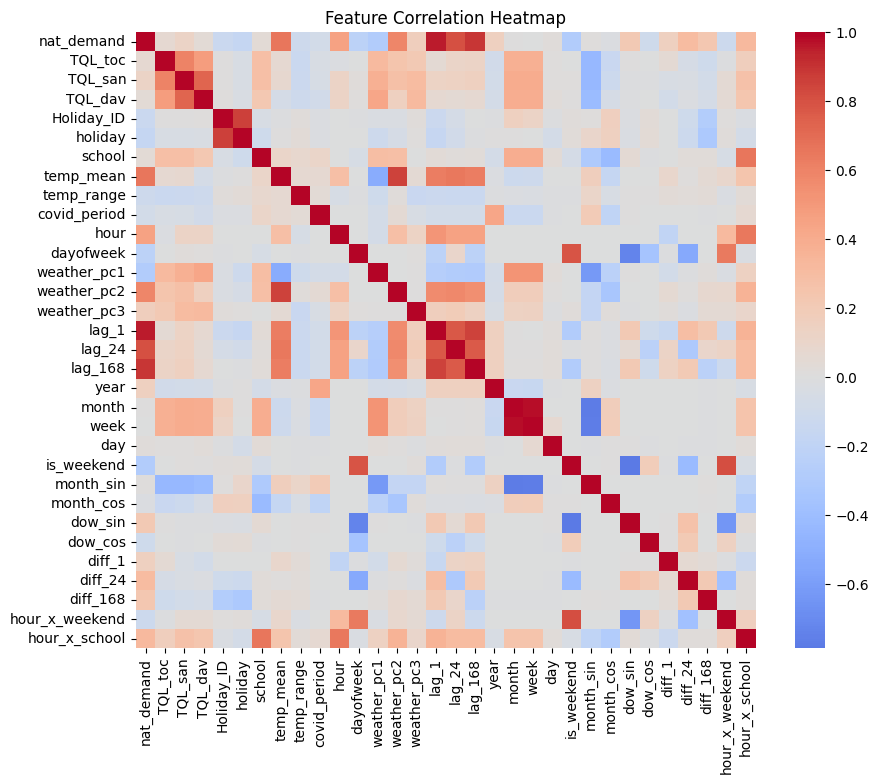

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(eng_df.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

The correlation heatmap shows that electricity demand is primarily driven by past consumption patterns (weekly lags), with moderate influence from weather conditions and calendar effects, confirming that the engineered feature set captures the key seasonal and behavioral drivers of demand.

## 6. Final Dataset Summary

After preprocessing and feature engineering, the final dataset captures the key drivers of electricity demand: short-term and weekly consumption patterns, weather conditions summarized via PCA, cyclical time effects, and calendar-based behavioral signals. The resulting feature set is compact, non-redundant, and specifically structured to support both tree-based and sequence-based forecasting models.

The dataset spans several thousand hourly observations from 2015 to mid-2020 and is formatted for use across multiple modeling approaches, including XGBoost, LSTM, and Temporal Fusion Transformers.

**Final Data Output**
- Location: `data/worked/engineered_dataset.csv`
- Time granularity: Hourly
- Coverage: 2015–2020
- Feature count: **30 engineered predictors** + target (`nat_demand`)

This engineered dataset serves as the consistent input foundation for all forecasting experiments that follow.


**End of Notebook**